# Navigation Project - Report

---

In this notebook, a solution to the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) is provided. Specifically, a Deep-Q-network is trained to play the Unity-Banana game and maximize the reward score.

This jupyter notebook is designed to serve as report for the project, by providing all necessary details of the learning algorithm used.
At the same time, the notebook also serves as training/testing of the agent to play the game.

## Implementation

- A Deep Q-Network (DQN) learning algorithm is implemented using pytorch to perform the given task.

- The DQN has 4 fully connected layers with ReLU activation function, where `input_size` is the number of states
    in the environment, here `37`. `output_size` is the number of actions possible for the agent; here `4`.
    In between, `FC` equal to `[64, 48, 24]` determines the size of the hidden layers in this project.
    The activation function for the last layer is softmax, to ensure output probability sums up to 1.
    ```
        ('fc1', nn.Linear(input_size, FC[0]))
        ('reLU', nn.ReLU())
        ('fc2', nn.Linear(FC[0], FC[1]))
        ('reLU', nn.ReLU())
        ('fc3', nn.Linear(FC[1], FC[2]))
        ('reLU', nn.ReLU())
        ('fc4', nn.Linear(FC[2], output_size))
    ```

    The Q-network is tasked with the objective to find the optimal policy π* for the agent.
    ```
    Q(s,a) = Q(s, a) + α[R(s, a) + γmaxQ'(s',a')-Q(s,a)]
    ```
    
- Prioritized Experience Replay: A buffer is implemented to provide sufficient experiences to
    the agent from its memory. This helps re-using the experiences as the agent gets trained.
    Furthermore, keeping high priority on re-learning experiences from memory with high td error
    helps the agent learn more from useful experiences than otherwise.

- Fixed target implementation: A double DQN approach is also adopted where the 2 sets of DQN
    are maintained by the agent i.e. local and target. The local network is the one trained at
    specific intervals. However, for evaluation of the agent's performance is based on the target
    network which slowly converges to local network. This approach ensures that the recently
    learned info by the local network doesn't disrupt the overall performance of the agent.
    Furthermore, the approach makes the network learn slowly but tends to converge to learn correct
    experiences over long periods.

- Soft update: To update the weights of the target network, a simple weighted average between
    the local and the target network is performed periodically. Depending on the weight, the
    target network undergoes a soft update with respect to the high-frequency varying local
    network.
    
- Hyperparameters: Several hyperparameters are used in the training/testing process, details
    of which are given below. Further, the specific values of the parameters used during
    the training session are stored in `log_path` file. Similarly, the graph of score vs episode
    is stored as `fig_path` file. Users are requested to examine these two files for the training
    performance.

## 1. Setup parameters (User-input required)

Tune the following parameters to obtain necessary results.

NOTE: Ensure `train_flag=False` and that `checkpoint.pth` file is available in the current folder if an already trained model is to be tested.

In [1]:
# Training parameters
train_flag = True # Set True if wish to train a network, else set False for testing
SEED = 5 # Set user-defined seed to ensure same results, else set False for random seed

priority_flag = True # Set True if wish to use priority sampling from Replay Buffer for training
LR_decay_flag = False # Set True if wish to decay learning rate while training

# Environment parameters
qualify_score = 13 # Score at which the training must stop
score_window = 100 # Number of episodes for which the qualify score should be maintained as average

# QNN parameters
FC = [64, 48, 24] # Neurons in the hidden fully connected layers
BATCH_SIZE = 32 # Number of samples/batch for training the Q network

LR = 1e-4 # Learning rate
LR_DECAY_RATE = 0.99 # Learning rate decay rate
LR_DECAY_STEP = int(BATCH_SIZE/5) # Learning rate decay step

# DRL parameters
steps_max = 500 # Maximum number of steps to be taken in an episode
train_episodes = 2048 # Number of episodes for which the agent must be trained (set as 50*BATCH_SIZE+1)

eps_init = 1.0 # Initial epsilon for epsilon greedy
eps_decay = 0.94 # The value by which the initial epsilon must decay over-time
eps_min = 0.001  # The minimum value of epsilon beyond which there should be no decay

SAMPLE_IMP = 0.75 # Amount of importance for prioritized sampling to those with high td estimate
TAU = 1e-3 # The degree of influence the target network has on the main/local network
UPDATE_EVERY = 4 # Number of time-steps in an episode after which the Q network should be updated

BUFFER_SIZE = min([steps_max*train_episodes, 2**15]) # Number of episodes to keep in memory (experience replay)
GAMMA = 0.98 # Discount factor of the rewards

# Extra variables for ease of use
app_path = 'Banana_Linux/Banana.x86_64'
model_path = 'checkpoint.pth'

log_path = 'output.txt'
fig_path = 'output.pdf'
loss_flag = False

# # Values for input normalization - this step doesn't seem to help much
# MAX_LINEAR_VEL = 12.5 # rough estimation for NN input normalization
# MAX_ANGULAR_VEL = 4.0 # rough estimation for NN input normalization

## 2. Import necessary libraries

In [2]:
# Environment
from unityagents import UnityEnvironment

# NN
import torch as tc
from torch import nn, optim
import torch.nn.functional as F

# Replay buffer
from collections import namedtuple, deque

# General
import numpy as np
from time import sleep, time
import matplotlib.pyplot as plt
%matplotlib inline

## 3. Setup the Unity environment

In [3]:
# Setup environment
env = UnityEnvironment(file_name=app_path)
device = tc.device("cpu") # Found CPU is good enough for this simple training
# device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu")

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# get environment details
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 4. Build Deep Q-Network

The following class builds a generic NN model with only FC layers and ReLU activation function (using `pytorch`).
The size and number of layers are tunable.

Later in Sectio 5, this class is used to create DQN using the following architecture:
    - Three fully connected layers with ReLU activation function
    - Input layer is of size `state_size` (i.e. the number of state variables, 37 in our case)
    - Second layer is of size `FC[1]`
    - Third layer is of size `FC[2]`
    - Fourth layer is of size `FC[3]`
    - Output layer is of size `action_size` (i.e. the number of possible actions, 4 in our case)

Also, later in Section 8, model parameters are loaded for testing if `train_flag=False`.

In [4]:
# Convert to a standard model
class DQN(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, input_size, output_size, fc_units=[16], seed=False):
        """
        Build a simple Fully Connected neural network with n hidden layers and ReLU activation.

        Param
        =====
            input_size (int): Dimension of input layer
            output_size (int): Dimension of output layer
            fc_units (list of int): Number of nodes in each hidden layer, also setting the number of hidden layers
            seed (int): Random seed
        """
        
        super(DQN, self).__init__()

        if seed:
            self.seed = tc.manual_seed(seed)
        
        self.model = nn.Sequential(
            nn.Linear(input_size, fc_units[0]),
            nn.ReLU(),
        )

        for i in range(len(fc_units)-1):
            self.model = nn.Sequential(
                self.model,
                nn.Linear(fc_units[i], fc_units[i+1]),
                nn.ReLU(),
            )
        
        self.model = nn.Sequential(
            self.model,
            nn.Linear(fc_units[len(fc_units)-1], output_size)
#             ,
#             nn.Softmax(dim=1) # This tends to decrease learning performance
        )
        
    def forward(self, input_):
        """
        Return a forward pass on the input
        
        Param
        =====
            input (list of size input_size_): Input to the model
        
        Return
        =====
            output from model (list of size output_size)
        """
        
        return self.model(input_)

## 5. Create a Replay Buffer

Experience replay is a key technique behind many recent advances in deep reinforcement learning.
Allowing the agent to learn from earlier memories can speed up learning and break undesirable temporal correlations.
A replay buffer stores all the past memories upto `relay_buffer_size` length.

In [5]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", \
                                     field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = np.random.seed(seed)
        
        if priority_flag:
            self.priority=deque(maxlen=buffer_size)
        
    def add(self, state, action, reward, next_state, done, td_error=0.0):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
        if priority_flag:
            priority = max([td_error, 1e-10]) # Maintain non-zero priority
            self.priority.append(priority)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""

        len_memory = len(self.memory)
        list_memory = list(self.memory)
        if priority_flag:
            # Priority sampling
            priorities = np.array(self.priority)**SAMPLE_IMP
            sampling_prob = list( priorities / np.sum(priorities) )
            indices = np.random.choice(len_memory, size=self.batch_size, p=sampling_prob)
            experiences = [list_memory[index] for index in indices]
        else:
#             # Random sampling
            indices = np.random.randint(0, len_memory-1, self.batch_size)
            experiences = [list_memory[index] for index in indices]
#             experiences = random.sample(self.memory, k=self.batch_size) # DEBUG:
        
        states = tc.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = tc.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = tc.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = tc.from_numpy(np.vstack([e.next_state for e in experiences \
                                                  if e is not None])).float().to(device)
        dones = tc.from_numpy(np.vstack([e.done for e in experiences \
                                            if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## 6. Create Agent

Create an agent to play the game and learn from it.
Notice that the agent uses both of the above defined classes to create required objects.

In [6]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = np.random.seed(seed)

        # Q-Network
        self.dqn_local = DQN(state_size, action_size, FC, SEED).to(device)
        self.dqn_target = DQN(state_size, action_size, FC, SEED).to(device)
        self.optimizer = optim.Adam(self.dqn_local.parameters(), lr=LR)
        
        if LR_decay_flag:
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=LR_DECAY_STEP, \
                                                       gamma=LR_DECAY_RATE)
            self.scheduler_epoch = 0 # Initialize epoch (episode) step

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        if loss_flag:
            self.loss_record = []
    
    def step(self, state, action, reward, next_state, done):
        
#         # State normalization (i.e. input to DQN) - this step doesn't seem to help much
#         state = np.array(state) # Copy value, don't use reference
#         next_state = np.array(next_state) # Copy value, don't use reference
#         state[35] /= MAX_ANGULAR_VEL
#         state[36] /= MAX_LINEAR_VEL
#         next_state[35] /= MAX_ANGULAR_VEL
#         next_state[36] /= MAX_LINEAR_VEL
        
        # Save experience in replay memory
        if priority_flag:
            # Priority sampling
            td_error = abs(reward + GAMMA * max(self.evaluate(next_state)) - self.evaluate(state)[action])
            self.memory.add(state, action, reward, next_state, done, td_error)
        else:
            # Random sampling
            self.memory.add(state, action, reward, next_state, done)
        
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
#         # State normalization (i.e. input to DQN) - this step doesn't seem to help much
#         state = np.array(state) # Copy value, don't use reference
#         state[35] /= MAX_ANGULAR_VEL
#         state[36] /= MAX_LINEAR_VEL
        
        state = tc.from_numpy(state).float().unsqueeze(0).to(device)
        self.dqn_local.eval()
        with tc.no_grad():
            action_values = self.dqn_local(state)
        self.dqn_local.train()

        # Epsilon-greedy action selection
        if np.random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.choice(np.arange(self.action_size))

    def evaluate(self, state):
        """
        Returns model output for given state.
        
        Params
        ======
            state (array_like): current state
        """
        
        # Send to torch
        state = tc.from_numpy(state).float().unsqueeze(0).to(device)
        
        # Get action values
        self.dqn_local.eval()
        with tc.no_grad():
            action_values = self.dqn_local(state)
        self.dqn_local.train()

        return action_values.cpu().data.numpy()[0]

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.dqn_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.dqn_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # DEBUG: Plot loss
        if loss_flag:
            self.loss_record.append(loss.detach().numpy())
            fig = plt.figure()
            plt.plot(np.arange(len(self.loss_record)), self.loss_record)
            plt.ylabel('loss')
            plt.xlabel('Batch #')
            plt.grid()
            fig.savefig('loss_record.pdf', bbox_inches='tight') # Vector graphics for detailed viz
            plt.close(fig)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.dqn_local, self.dqn_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


## 7: Train the network (only if `train_flag=True`)

NOTE: Training results are stored as `log_path` and the graph as `fig_path` files.

	 Episode: 100 Step: 250 Yellow Score: 00 Blue Score: 00 Score: 0.0
Episode: 100 Avg Time: 1.91s Avg Score: 1.8
	 Episode: 120 Step: 250 Yellow Score: 04 Blue Score: 01 Score: 3.00
Episode: 120 Avg Time: 1.95s Avg Score: 2.69
	 Episode: 140 Step: 250 Yellow Score: 07 Blue Score: 01 Score: 6.00
Episode: 140 Avg Time: 1.97s Avg Score: 3.82
	 Episode: 160 Step: 250 Yellow Score: 08 Blue Score: 00 Score: 8.00
Episode: 160 Avg Time: 1.99s Avg Score: 4.45
	 Episode: 180 Step: 250 Yellow Score: 01 Blue Score: 00 Score: 1.00
Episode: 180 Avg Time: 2.01s Avg Score: 4.81
	 Episode: 200 Step: 250 Yellow Score: 08 Blue Score: 00 Score: 8.00
Episode: 200 Avg Time: 2.03s Avg Score: 5.2
	 Episode: 220 Step: 250 Yellow Score: 02 Blue Score: 00 Score: 2.00
Episode: 220 Avg Time: 2.04s Avg Score: 5.03
	 Episode: 240 Step: 250 Yellow Score: 05 Blue Score: 00 Score: 5.00
Episode: 240 Avg Time: 2.04s Avg Score: 4.78
	 Episode: 260 Step: 250 Yellow Score: 04 Blue Score: 00 Score: 4.00
Episode: 260 Avg Time:

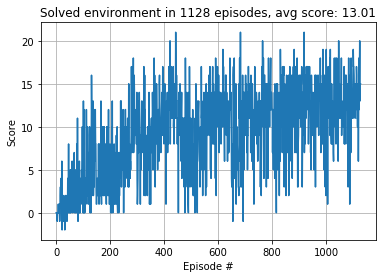

In [7]:
# Create an agent which interacts with the environment
agent = Agent(state_size, action_size, SEED)

if train_flag:

    # Setup variables
    all_scores = []
    steps_period = int(steps_max/10)
    episode_period = min([int(train_episodes/100), score_window])
    start_time = time()

    # Log info (such that browser can be safely closed)
    text = 'priority_flag = {}\nLR_decay_flag = {}\nqualify_score = {}\nscore_window = {}\nBATCH_SIZE = {}\n' + \
            'LR = {}\nLR_DECAY_RATE = {}\nLR_DECAY_STEP = {}\nFC = {}\n\ntrain_episodes = {}\n' + \
            'steps_max = {}\neps_init = {}\neps_decay = {}\neps_min = {}\nSAMPLE_IMP = {}\nTAU = {}\n' + \
            'UPDATE_EVERY = {}\nBUFFER_SIZE = {}\nGAMMA = {}\n\n'
    text = text.format(priority_flag, LR_decay_flag, qualify_score, score_window, BATCH_SIZE, LR, LR_DECAY_RATE,\
                       LR_DECAY_STEP, FC, train_episodes, steps_max, eps_init, eps_decay, eps_min, \
                       SAMPLE_IMP, TAU, UPDATE_EVERY, BUFFER_SIZE,GAMMA)
    with open(log_path,'w+') as file:
        file.write(text)

    for e in range(train_episodes):

        # Reset environment and setup variables
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0] # get the current state
        score = 0 # initialize the score
        yellow_bananas = 0
        blue_bananas = 0
        eps = eps_init # Initialize epsilon
        solved_flag = False
        if LR_decay_flag:
            agent.scheduler_epoch = e

        for t in range(steps_max):
            # Get next action from the agent
            action = agent.act(state, eps)

            # Run one step and collect env info
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            if reward == 1:
                yellow_bananas += 1
            elif reward == -1:
                blue_bananas += 1
            score += reward

            # Check if required average score is obtained
            if t % steps_period == 0:
                text = "\t Episode: {} Step: {:03} Yellow Score: {:02} Blue Score: {:02} Score: {:02}".format(\
                    e, t, yellow_bananas, blue_bananas, score)
                print(text, end = '\r')
                with open(log_path,'a+') as file:
                    file.write(text+'\n')

            if done:
                    all_scores.append(score)
                    break

            # Prepare for the next step
            agent.step(state, action, reward, next_state, done) # Store the information of last step
            state = next_state # Update state
            eps = max(eps_min, eps_decay*eps) # decrease epsilon


        # Check if required average score is obtained
        if len(all_scores) > score_window:
            if e % episode_period == 0:
                text = "Episode: {} Avg Time: {:0.2f}s Avg Score: {}".format(e, (time()-start_time)/e, \
                                                                            np.mean(all_scores[-score_window:]))
                with open(log_path,'a+') as file:
                    file.write(text+'\n')

                print()
                print(text)
                
                tc.save(agent.dqn_local.state_dict(), 'checkpoint_unoptimized.pth')

                # Plot the scores - for better viz, than just texts
                fig = plt.figure()
                plt.plot(np.arange(len(all_scores)), all_scores)
                plt.ylabel('Score')
                plt.xlabel('Episode #')
                plt.grid()
                fig.savefig(fig_path, bbox_inches='tight') # Vector graphics for detailed viz
                plt.close(fig)
                
            if np.mean(all_scores[-score_window:]) > qualify_score:
                text = "Solved environment in {} episodes, avg score: {}".format(\
                    e, np.mean(all_scores[-score_window:]))

                with open(log_path,'a+') as file:
                    file.write(text+'\n')
                
                print(text)
                
                tc.save(agent.dqn_local.state_dict(), 'checkpoint.pth')
                
                solved_flag = True
                
                break
                
        
    # Plot the scores
    fig = plt.figure()
    plt.plot(np.arange(len(all_scores)), all_scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    if solved_flag:
        plt.title(text)
    else:
        plt.title(text[2:])
    plt.grid()
    plt.show()
    fig.savefig(fig_path, bbox_inches='tight') # Vector graphics for detailed viz
    fig.savefig('rewards.png', bbox_inches='tight') # Raster graphics to show later in Section 9
    plt.close(fig)

## 8: Test the performance (only if `train_flag=False`)

Test an already trained agent.

In [8]:
if not train_flag:
    
    # Initialization
    agent.dqn_local.load_state_dict(tc.load('checkpoint.pth')) # load the weights from file
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0] # get the current state
    score = 0 # initialize the score
    
    while True:
        action = agent.act(state,0.0) # select an action
        env_info = env.step(action)[brain_name] # send the action to the environment
        next_state = env_info.vector_observations[0] # get the next state
        reward = env_info.rewards[0] # get the reward
        done = env_info.local_done[0] # see if episode has finished
        score += reward # update the score
        state = next_state # roll over the state to next time step
        if done: # exit loop if episode finished
            break

    print("Score: {}".format(score))

In [9]:
# Close environment
env.close()

## 9. Conclusion

### Plot of training rewards

![banana_agent_rewards](rewards.png)

NOTE: The above figure might not be the true figure due to disk cache problem. Please see `fig_path` file for the latest and true graph.

### Observations

There were a lot of observations and learnings during the training sessions:
- In this work, a Double DQN approach with Prioritized Experience Replay Buffer is implemented. This is because from personal exploration, a simple DQN didn't seem to train steadily i.e. avg score kept fluctuating a lot. Furthermore, in general, a random sampling in the replay buffer provided the torch optimizer with experience in which reward is typically 0 i.e. an experience which doesn't teach much useful information.
- Introduction of softmax to the output of the neural network tremendously reduces the
    performance of the learning. This is indeed surprising because typically the probabilistic output networks
    have softmax to ensure that output is probabilistic (i.e. 1<p<1 and sum(p) = 1).
- Input normalization, specifically the linear and angular velocity of the agent to [-1, 1], 
    doesn't seem to help with network learning.
- Learning rate decay of the network optimizer doesn't seem to help in improving learning rate,
    probably because this require precise tuning of the decay rate and initial value of the learning rate.
- Prioritized Replay Buffer helps increase the rate of learning substantially, although at the cost of
    computational time.
  
- The hyperparameters which suit well are designed such that the local network trains faster
    but slightly unstably, while the target network trains slowly and tries to make the prediction
    much more stable.
- There were numerous cases where the training performance increased rapidly, then decreased, followed by increase again in the average score. Such a situation might arise due to fast learning approach such as target network is updated to local network very fast, while the local network is being trained with small batch size with minimal data.
- For instance, in one of the sets of the training parameters, the avg score of +13 over 100 episodes was obtained within about 500 episodes. Although, the score graph was very noisy and the agent's performace during testing was very jerky, almost as if the agent was randomly choosing actions instead of continuously progressing towards a yellow banana.
- In constrast to above, several cases where also observed where the system doesn't learn much even after thousands of training episodes, simply because the training parameters were tuned to learn slowly. Accordingly, it is learned that the training parameters can significantly affect the system performance, beyond the learning algorithm itself.
- A lot of times, the average score increased and thereafter decrease after a number of episodes. This might be because the network is trained to learn faster, rather than learn a lot of good moves.
- It is also learned that there needs to be a trade-off between larger buffer size against slower convergence of target network to the local network, because otherwise, the network might forget good experiences very easily and start to work on poor results.
- Finally, a few trials with random initial network weights is a good approach to ensure trying out all potentially good possible results.

### Future Ideas

There were a lot of learning from our observations as mentioned above.
Luckily, there does exists a lot of algorithms (such as Actor-Critic approach, DDPG, etc.) in the literature which focus on overcoming the short-coming of the Deep Q-Network approach implemented in this work.
Hence, in future, it is worth exploring other algorithms for improving the agent's performance.